In [2]:
import io
import fitz
import re
from PIL import Image, ImageDraw, ImageFont, ImageColor
import operator
import pandas as pd 
import numpy as np
import math
from tqdm import tqdm

# ROI Plotting

In [3]:
def plot_genus_blocks(page_df, draw, color = '#6c899e', w = 3):
    genus_list = page_df['genus'].unique()
    for c in page_df['col'].unique():
        for g in genus_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['genus'] == g)]
            g_x0 = temp_df['x0'].min()
            g_y0 = temp_df['y0'].min()
            g_x1 = temp_df['x1'].max()
            g_y1 = temp_df['y1'].max()

            draw.rectangle((g_x0, g_y0, g_x1, g_y1), fill=None, outline=ImageColor.getrgb(color), width = w)
        
def plot_epitet_blocks(page_df, draw, color = '#54081f', w = 2):
    epitet_list = page_df['epitet'].unique()
    for c in page_df['col'].unique():
        for s in epitet_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['epitet'] == s)]
            for g in temp_df['genus'].unique():
                    
                temp_g_df = temp_df[(temp_df['genus']) == g]
                s_x0 = temp_g_df['x0'].min()
                s_y0 = temp_g_df['y0'].min()
                s_x1 = temp_g_df['x1'].max()
                s_y1 = temp_g_df['y1'].max()

                draw.rectangle((s_x0, s_y0, s_x1, s_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

def plot_blocks(page_df, draw, color = '#4a3757', w = 2):
    block_list = page_df['block_no'].unique()
    for i in block_list:
        df_groupped = page_df[page_df['block_no'] == i]
        x0_arr = df_groupped['x0'].min()
        y0_arr = df_groupped['y0'].min()
        x1_arr = df_groupped['x1'].max()
        y1_arr = df_groupped['y1'].max()

        draw.rectangle((x0_arr, y0_arr, x1_arr, y1_arr), fill=None, outline=ImageColor.getrgb(color), width = w)

def plot_author_blocks(page_df, draw, color = '#a3a3a3', w = 1):
    epitet_list = page_df['epitet'].unique()
    for c in page_df['col'].unique():
        for s in epitet_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['epitet'] == s)]
            for g in temp_df['genus'].unique():
                temp_g_df = temp_df[(temp_df['genus'] == g) & (temp_df['word'] != s)]
                a_x0 = temp_g_df['x0'].min()
                a_y0 = temp_g_df['y0'].min()
                a_x1 = temp_g_df['x1'].max()
                a_y1 = temp_g_df['y1'].max()
                
                draw.rectangle((a_x0, a_y0, a_x1, a_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

def plot_sub_blocks(page_df, draw, color = '#ff6289', w = 1):
    sub_list = page_df[(~page_df['sub'].isnull())]['sub'].unique()
    for c in page_df['col'].unique():
        for s in sub_list:
            temp_df = page_df[(page_df['col'] == c) & (page_df['sub'] == s)]
            for b in temp_df['block_no'].unique():
                temp_b_df = temp_df[(temp_df['block_no'] == b)]
                for l in temp_b_df['line_no'].unique():
                    temp_l_df = temp_b_df[temp_b_df['line_no'] == l]
                    a_x0 = temp_l_df['x0'].min()
                    a_y0 = temp_l_df['y0'].min()
                    a_x1 = temp_l_df['x1'].max()
                    a_y1 = temp_l_df['y1'].max()
                
                    draw.rectangle((a_x0, a_y0, a_x1, a_y1), fill=None, outline=ImageColor.getrgb(color), width = w)

# Vol3 Index

In [4]:
pdf_dir = "../input/NOUVELLE FLORE DU LIBAN ET DE LA SYRIE 3.pdf"
doc = fitz.open(pdf_dir)
pages = [doc[i] for i in range(doc.pageCount)]
index = list(range(555, 583))

TARGET_DPI = 300
mat = fitz.Matrix(TARGET_DPI/ 72, TARGET_DPI/ 72)

indent_groups = []
indent_err = 15

In [28]:
def valid(word):
    """
    valid words are words that are:
    - at least 2 characters
        - unless it's x (symbol for hybrid)
    """
    return (not bool(re.search(r"[0-9]+[,.]?", word))) and (len(word) > 1 or word == 'x' or word == 'X' or word == '×')

def preprocessing(page_num, indent_err = 15):
    
    #initiate dataframe
    page_df = pd.DataFrame(pages[page_num].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])
    
    #add page number to dataframe
    page_df['page_num'] = np.array([page_num]*page_df.shape[0])
    #updating coordinates to represent target DPI
    page_df['x0'], page_df['y0'], page_df['x1'], page_df['y1'] = page_df['in_x0']*TARGET_DPI/ 72, page_df['in_y0']*TARGET_DPI/ 72, page_df['in_x1']*TARGET_DPI/ 72, page_df['in_y1']*TARGET_DPI/ 72
    #get x corner coordinates 
    x_min = page_df['x0'].min()
    x_max = page_df['x1'].max()

    #invalid words dataframe -- for error checking
    pruned_words_df = page_df[~page_df["word"].apply(valid)].reset_index()
    #prune out invalid words (based on function valid)
    page_df = page_df[page_df["word"].apply(valid)].reset_index()
    
    indent_groups = []
    for b in page_df['block_no'].unique():
        for l in page_df['line_no'].unique():
            #reset word_no values (useful for cases where word that was originally at 0th index was pruned out)
            num_words = len(page_df[(page_df['line_no'] == l) & (page_df['block_no'] == b)]['word_no'])
            page_df.loc[(page_df['line_no'] == l) & (page_df['block_no'] == b), 'word_no'] = np.arange(num_words).astype(int) #this is slowww
            #set column number (0 or 1)
            x_0 = page_df[(page_df['line_no'] == l) & (page_df['block_no'] == b)]['x0'].min()
            #THIS DOESN'T WORK AAAA
            if not np.isnan(x_0):
                page_df.loc[(page_df['line_no'] == l) & (page_df['block_no'] == b), 'col_no'] = np.array([int(x_0 > ((x_min + x_max) / 2))]*num_words).astype(int)

                #initiate indent groups -- only first word should get an indent_group value 
                new_group = True
                for g_i in range(len(indent_groups)):
                    g = indent_groups[g_i]
                    g_arr = np.array(g)
                    if x_0 <= np.mean(g_arr) + indent_err and x_0 >= np.mean(g_arr) - indent_err:
                        g.append(x_0)
                        new_group = False
                        page_df.loc[(page_df['line_no'] == l) & (page_df['block_no'] == b) & (page_df['word_no'] == 0), 'indent_group'] = np.array(g_i)
                if new_group:
                    indent_groups.append([x_0])
                    g_i = len(indent_groups) - 1
                    page_df.loc[(page_df['line_no'] == l) & (page_df['block_no'] == b) & (page_df['word_no'] == 0), 'indent_group'] = np.array(g_i)


    #return updated page_df, pruned_words_df, indent groups
    return page_df.reset_index(), pruned_words_df, indent_groups

#https://stackoverflow.com/questions/53468558/adding-image-to-pandas-dataframe

In [29]:
genus = np.NaN
result_ims = []
df_list = []
pruned_list = []

for page_num in tqdm(index):
    page_df, pruned_df, indent_group = preprocessing(page_num)
    df_list.append(page_df)
    pruned_list.append(pruned_df)
    
    break
#result_ims[0].save('../output/index/PDF/vol3_withSub_ROIV2.pdf',save_all=True, append_images=result_ims[1:])


  0%|          | 0/28 [00:03<?, ?it/s]


In [31]:
len(indent_group)

8

In [32]:
df = pd.concat(df_list, axis = 0)
pruned_df = pd.concat(pruned_list, axis = 0)

In [33]:
df.to_html('../output/index/vol3.html')

In [37]:
genus = np.NaN
result_ims = []
df_list = []

i=0
for page_num in tqdm(index):
    #page_df = df_list[i]
    i+=1
    #get_author(page_df)
    
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    plot_blocks(page_df, draw, w = 4)
    #plot_epitet_blocks(page_df, draw, w = 3)
    #plot_author_blocks(page_df, draw, w = 2)
    #plot_sub_blocks(page_df, draw, w = 1)

    #df_list.append(page_df)
    result_ims.append(image)
    break
#result_ims[0].save('../output/index/PDF/vol3_withSub_ROIV2.pdf',save_all=True, append_images=result_ims[1:])


  0%|          | 0/28 [00:00<?, ?it/s]


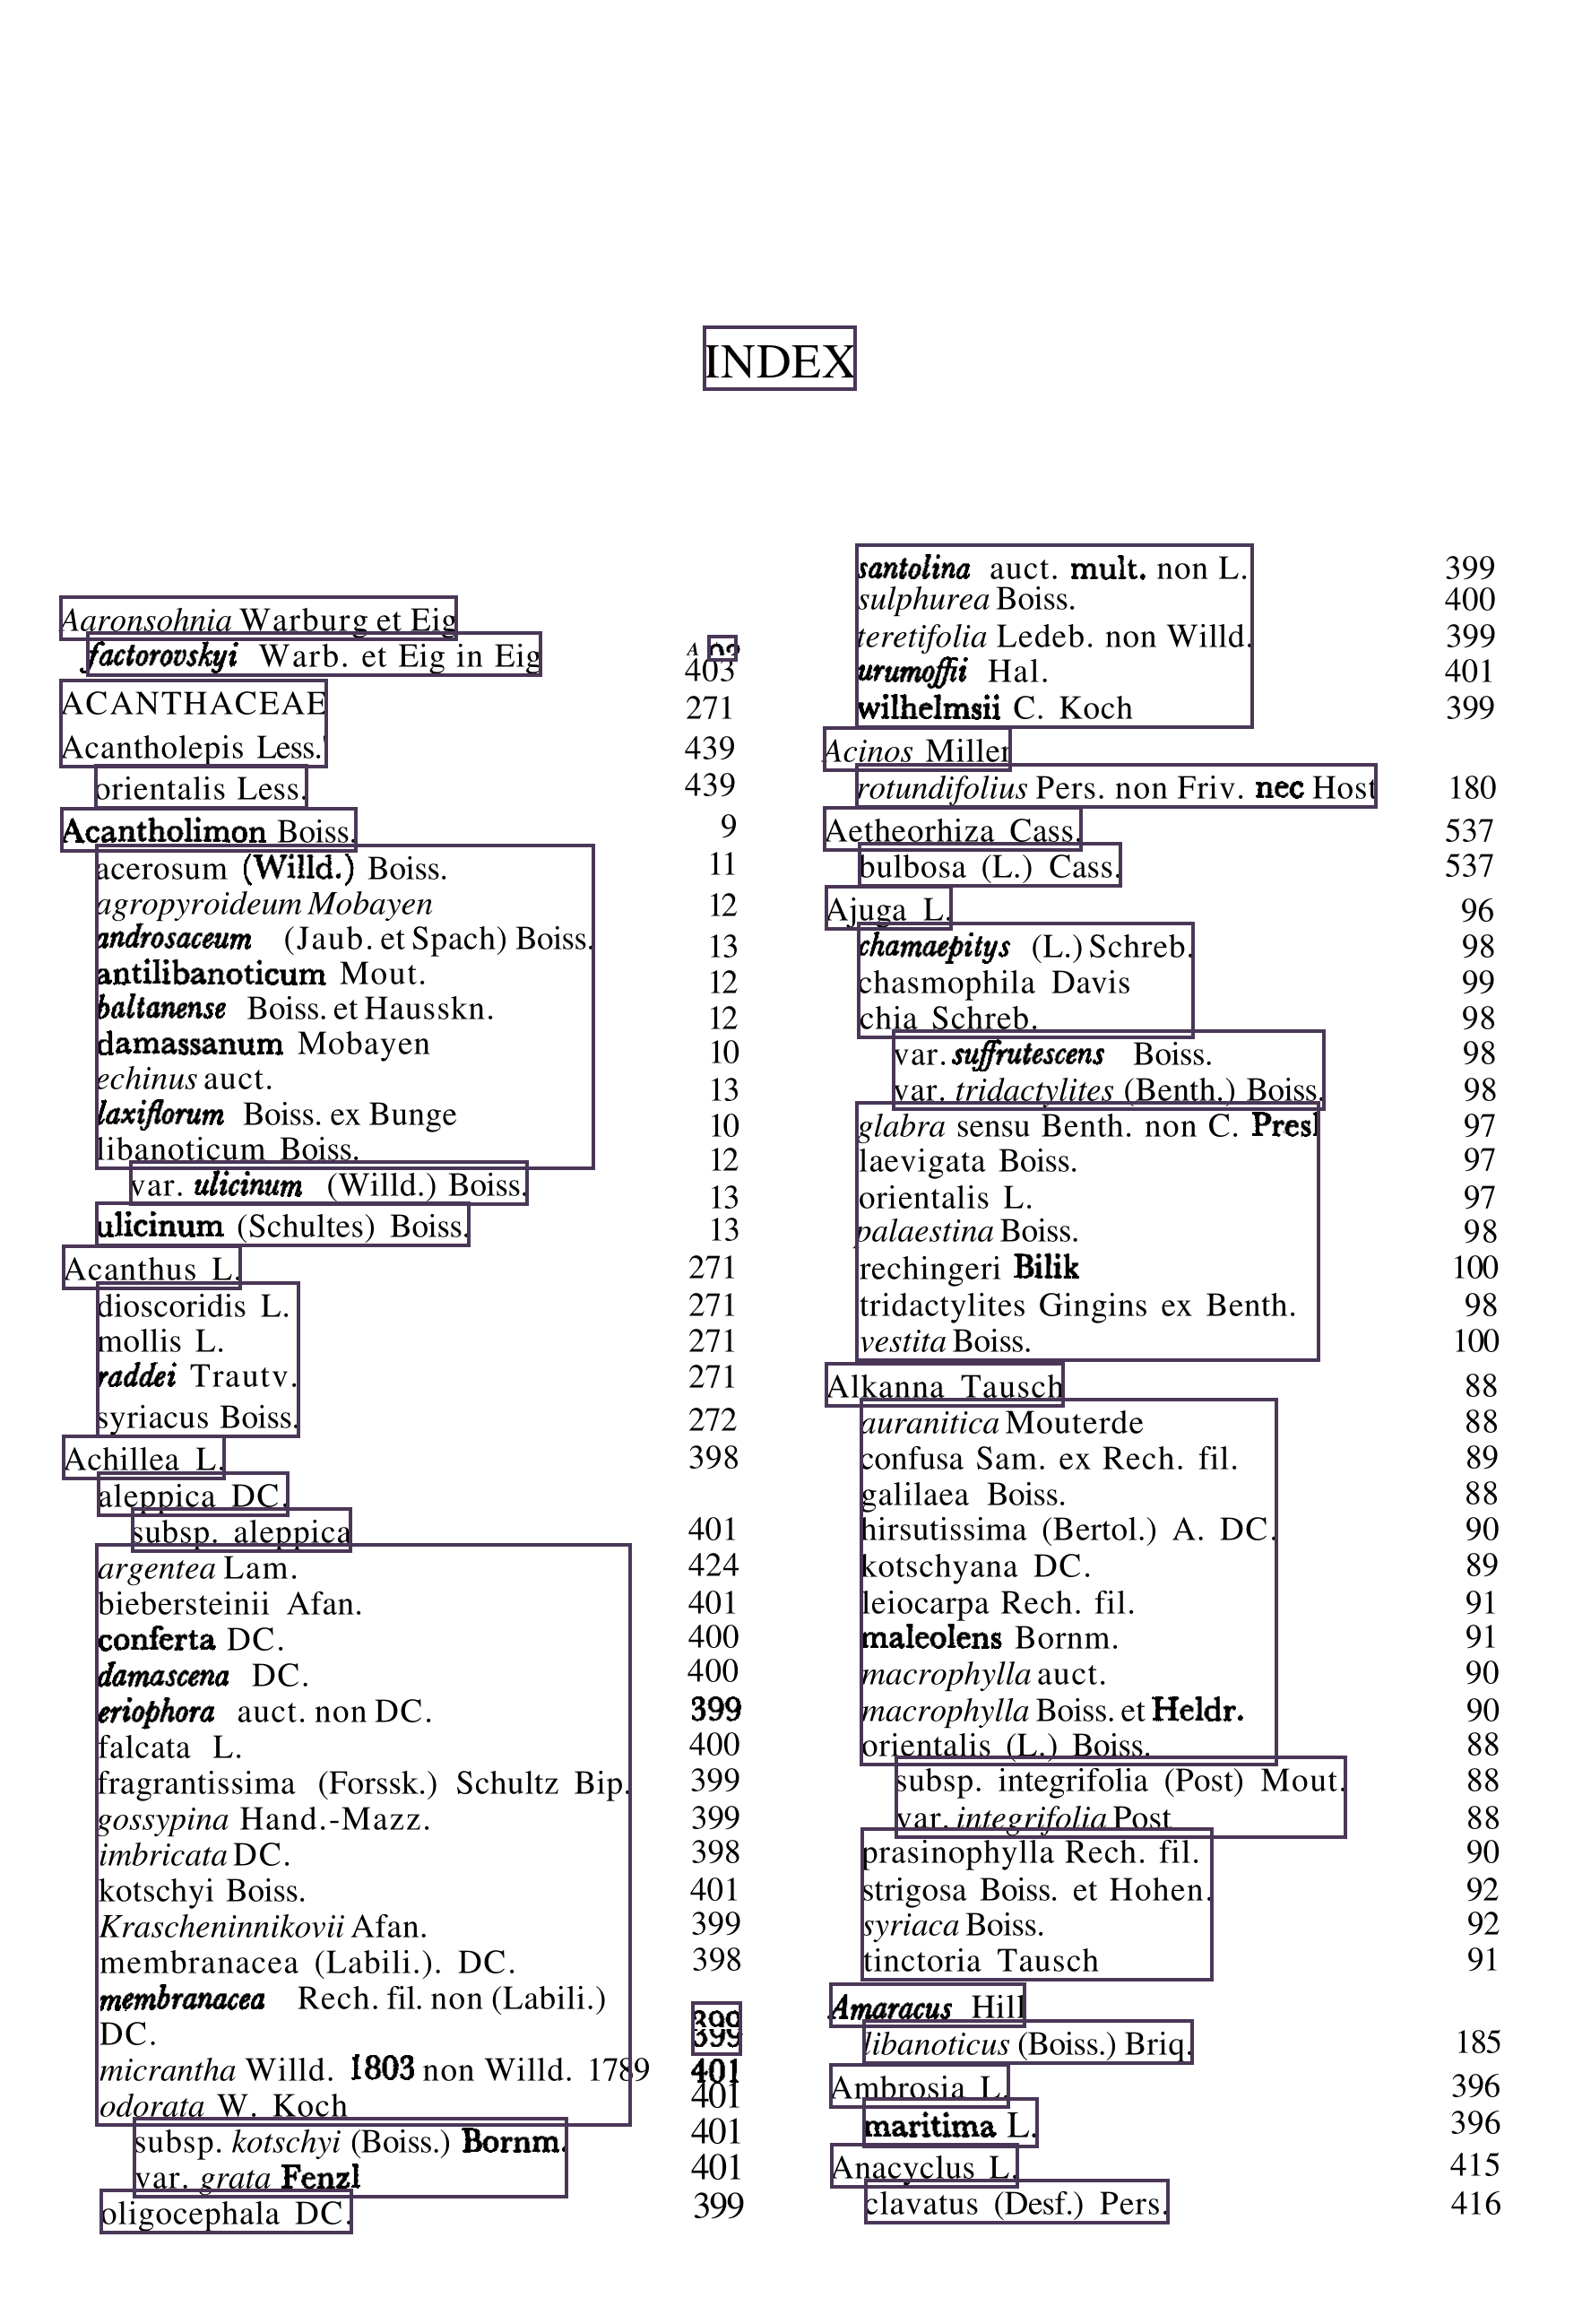

In [38]:
image

In [ ]:
def process_df(page_num, genus = np.NaN, genus_block_no = np.NaN):
    def initiate_groups(row):
        #return row
        x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
        word_no = row['word_no']
        word = row['word']
        alphnum_word = ''.join(e for e in word if e.isalnum())
        alph_word = ''.join(e for e in word if e.isalpha())
        
        if row['line_no'] == 0 and (word.lower() == 'nouvelle' or word.lower() == 'flore'):
            return 
        if (word_no == 0) and (not alphnum_word.isnumeric()) and alph_word:
            #word_no == 0 => the word is a Family, Genus, Species
            new_group = True
            for g in indent_groups:
                g_arr = np.array(g)[:,0]
                if (x_0, y_0, x_1, y_1)[0] <= np.mean(g_arr) + indent_err and (x_0, y_0, x_1, y_1)[0] >= np.mean(g_arr) - indent_err:
                    g.append((x_0, y_0, x_1, y_1))
                    new_group = False
            if new_group:
                indent_groups.append([(x_0, y_0, x_1, y_1)])

    def get_indent_group(row):
        x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
        word_no = row['word_no']
        word = row['word']
        alphnum_word = ''.join(e for e in word if e.isalnum())
        
        if (len(word) > 1) and ((not alphnum_word.isnumeric()) and (word_no == 0)): 
            for g_i, g in enumerate(indent_groups):
                g_arr = np.array(g)[:,0]
                if (x_0, y_0, x_1, y_1)[0] <= np.mean(g_arr) + indent_err and (x_0, y_0, x_1, y_1)[0] >= np.mean(g_arr) - indent_err:
                    return g_i

    def get_col(row): 
        x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']
        return int(x_0 > ((x_min + x_max) / 2))

    def n_leftmost_indent(indent_groups, n):
        indent_means = []
        for g_i, g in enumerate(indent_groups):
            g_arr = np.array(g)[:,0]
            indent_means.append([g_i, np.mean(g_arr)])

        n_smallest = indent_means.sort(key = lambda x : x[1])[:n] #n smallest
        return [el[0] for el in n_smallest]

    def process_col(row):
        nonlocal genus
        nonlocal x_0, y_0, x_1, y_1 
        nonlocal epitet
        nonlocal sub
        nonlocal genus_block_no
        word_no = row['word_no']
        block_no = row['block_no']
        line_no = row['line_no']
        word = row['word']
        row['epitet'] = np.NaN
        row['genus'] = np.NaN
        row['sub'] = np.NaN
        
        alph_word = ''.join(e for e in word if e.isalpha())

        if line_no == 0 and (word.lower() == 'nouvelle' or word.lower() == 'flore'):
            return row

        if (not (word.isupper() and word_no == 0)) and len(word) > 1  and alph_word:
            if word_no == 0: #epitet, or genus
                x_0, y_0, x_1, y_1 = row['x0'], row['y0'], row['x1'], row['y1']

            alphnum_word = ''.join(e for e in word if e.isalnum())
            if (not alphnum_word.isnumeric()): 
                if  x_0 <= g_x0 + indent_err and x_0 >= g_x0 - indent_err:
                    if word_no == 0:
                        genus = word
                        row['genus'] = genus
                        genus_block_no = row['block_no']
                    elif word_no != 0 and line_no == 0 and block_no == genus_block_no: #info on same line as genus
                        #epitet = word
                        #print(genus, alphnum_word)
                        row['epitet'] = np.NaN
                        row['genus'] = genus
                        #row['author']"""
                        row['sub'] = np.NaN
                    else:
                        row['epitet'] = epitet
                        row['genus'] = genus
                        row['sub'] = np.NaN
                elif x_0 <= s_x0 + indent_err and x_0 >= s_x0 - indent_err:
                    if word_no == 0:
                        epitet = word
                        sub = ''
                    row['epitet'] = epitet
                    row['genus'] = genus
                    row['sub'] = np.NaN
                elif x_0 <= sub_x0 + indent_err and x_0 >= sub_x0 - indent_err:
                    #word_no == 0 and (word == 'var.' or word == 'subsp.' or word == 'x' or word == 'X'): #assuming at least genus line exists
                    if word_no == 0:
                        sub = word
                    row['epitet'] = epitet
                    row['genus'] = genus
                    #print(word_no)
                    row['sub'] = sub + " " + genus + " " + epitet

        return row

    #page_df = pd.DataFrame(pages[page_num].get_text_words(), columns =['in_x0', 'in_y0', 'in_x1', 'in_y1', 'word', 'block_no', 'line_no', 'word_no'])
    #page_df['page_num'] = np.array([page_num]*page_df.shape[0])
    #page_df['x0'], page_df['y0'], page_df['x1'], page_df['y1'] = page_df['in_x0']*TARGET_DPI/ 72, page_df['in_y0']*TARGET_DPI/ 72, page_df['in_x1']*TARGET_DPI/ 72, page_df['in_y1']*TARGET_DPI/ 72
    page_df = preprocessing(page_num)
    indent_groups = []
    indent_err = 15
    sub = ''
    x_min = page_df['x0'].min()
    y_min = page_df['y0'].min()
    x_max = page_df['x1'].max()
    y_max = page_df['y1'].max()
    
    page_df.apply(initiate_groups, axis = 1)
    page_df['indent_group'] = page_df.apply(get_indent_group, axis = 1)

    page_df['col'] = page_df.apply(get_col, axis = 1)
    
    x_0, y_0, x_1, y_1, epitet = np.NaN, np.NaN, np.NaN, np.NaN, np.NaN
    for c in page_df['col'].unique():
        
        # what if just one largest? what would that even mean? Hm ... (like what if it's all)
        col_df = page_df[(page_df['col'] == c)]
        col_indent_groups =  list(col_df[~col_df['indent_group'].isnull()]['indent_group'].unique())
        #n_leftmost = n_leftmost_indent(col_indent_groups, 2)
        #col_df[col_df['indent_group'] == s_indent]
        #if len(n_leftmost) == 2:

        s_x0, g_x0, sub_x0 = float('inf'), float('inf'), float('inf')
        s_indent, g_indent, sub_indent = -1, -1, -1

        for g in col_indent_groups:
            mean_x0 = col_df[col_df['indent_group'] == g]['x0'].mean()
            sub_list = ["var.", "subsp.", "x", "X"]

            if (col_df[col_df['indent_group'] == g]['word'].apply(lambda x : x  in sub_list)).any():
                sub_indent = g
                sub_x0 = mean_x0
            if g_x0 > mean_x0:
                s_indent, g_indent = g_indent, g
                s_x0, g_x0 = g_x0, mean_x0 
            elif s_x0 > mean_x0: #and g_x0 <= mean_x0
                s_indent = g
                s_x0 = mean_x0
            """elif sub_x0 > mean_x0:#and g_x0 <= mean_x0 and s_x0 <= mean_x0
                sub_indent = g
                sub_x0 = mean_x0"""

        #if col_df[col_df['indent_group'] == s_indent]['word'].str.contains('var.|subsp.').any():
        
        #print(genus, s_x0, g_x0)


        """species_indent_df = col_df[col_df['indent_group'] == s_indent]
        if (species_indent_df['word'] == 'var.').any() or (species_indent_df['word'] == 'subsp.').any() or (species_indent_df['word'] == 'x').any() or (species_indent_df['word'] == 'X').any():
            s_x0, g_x0, sub_x0 = g_x0, float('inf'), s_x0
            s_indent, g_indent, sub_indent = g_indent, -1, s_indent
            #print("no genus in a column of page", page_num)

        if (s_x0  < g_x0): #the swap thing doesn't account for sub_indent level just yet ... 
            s_x0, g_x0 = g_x0, s_x0
            s_indent, g_indent = g_indent, s_indent

        if s_indent == -1: #subspecies must not exist in this case so won't worry about it 
            s_x0, g_x0 = g_x0, float('inf')
            s_indent, g_indent = g_indent, -1

        col_df = col_df.apply(process_col, axis = 1)
        page_df.loc[col_df.index, ['genus', 'epitet', 'sub']] = col_df.loc[col_df.index, ['genus', 'epitet', 'sub']]
        #print("g_x0, s_x0, g_indent, s_indent:", g_x0, s_x0, g_indent, s_indent)"""
        species_indent_df = col_df[col_df['indent_group'] == s_indent]
        if (species_indent_df['word'] == 'var.').any() or (species_indent_df['word'] == 'subsp.').any():
            s_x0, g_x0 = g_x0, float('inf')
            s_indent, g_indent = g_indent, -1
            #print("no genus in a column of page", page_num)

        if (s_x0  < g_x0):
            s_x0, g_x0 = g_x0, s_x0
            s_indent, g_indent = g_indent, s_indent

        if s_indent == -1:
            s_x0, g_x0 = g_x0, float('inf')
            s_indent, g_indent = g_indent, -1
    #print("genus", genus)
        col_df = col_df.apply(process_col, axis = 1)
        page_df.loc[col_df.index, ['genus', 'epitet', 'sub']] = col_df.loc[col_df.index, ['genus', 'epitet', 'sub']]
    return page_df, genus

In [ ]:
def get_author(page_df):
    #pruned_df = page_df[(~page_df['genus'].isnull())].reset_index()
    epitet_names = page_df[~page_df['epitet'].isnull()]['epitet'].unique()
    genus_names = page_df[~page_df['genus'].isnull()]['genus'].unique()
    sub_names = page_df[~page_df['sub'].isnull()]['sub'].unique()
    for i in range(len(page_df['x0'])):
        word = page_df.loc[i, 'word']
        sub = page_df.loc[i, 'sub']
        line_no = page_df.loc[i, 'line_no']
        block_no = page_df.loc[i, 'block_no']
        if word in epitet_names:
            #print(word, i)
            s = page_df.loc[i, 'word']
            g = page_df.loc[i, 'genus']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['epitet'] == s) & (page_df['word'] != s)]
            
            merged = sub_df.groupby('epitet')['word'].agg(' '.join).reset_index()
            
            concat_str = np.NaN
            if len(merged.index):
                concat_str = merged['word'].item()
            
            page_df.loc[i, 'author'] = concat_str
            page_df.loc[i, 'sub_type'] = np.NaN
            page_df.loc[i, 'sub_name'] = np.NaN

        if word in genus_names:
            g = page_df.loc[i, 'genus']
            g_block_no = page_df.loc[i, 'block_no']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['block_no'] == g_block_no) & (page_df['word_no'] != 0) & (page_df['line_no'] == 0)]
            merged = sub_df.groupby('genus')['word'].agg(' '.join).reset_index()
            concat_str = np.NaN
            if len(merged.index):
                #print(g, word)
                concat_str = merged['word'].item()
            page_df.loc[i, 'author'] = concat_str
            page_df.loc[i, 'sub_type'] = np.NaN
            page_df.loc[i, 'sub_name'] = np.NaN
        if sub in sub_names:
            #print(sub.split(' '))
            sub_type, g, s = sub.split(' ')#[0]
            #s = page_df.loc[i, 'word']
            #g = page_df.loc[i, 'genus']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['epitet'] == s) & \
                            (page_df['word'] != sub_type) & (page_df['sub'] == sub) & (page_df['line_no'] == line_no) & (page_df['block_no'] == block_no)]
            merged = sub_df.groupby('sub')['word'].agg(' '.join).reset_index()
            concat_str = np.NaN
            name, aut = np.NaN, np.NaN
            if len(merged.index):
                #print(g, word)
                concat_str = merged['word'].item()
                #print(concat_str)
                #print(concat_str.split(' ', 1))
                if len(concat_str.split(' ', 1)) == 2:
                    name, aut = concat_str.split(' ', 1)
                elif len(concat_str.split(' ', 1)) == 1:
                    name = concat_str
            page_df.loc[i, 'sub_type'] = sub_type
            page_df.loc[i, 'sub_name'] = name
            page_df.loc[i, 'sub_author'] = aut


In [ ]:
genus = np.NaN
result_ims = []
df_list = []

for page_num in tqdm(index):
    page_df, genus = process_df(page_num, genus)
    get_author(page_df)
    
    pix_map = doc.get_page_pixmap(page_num,matrix=mat)
    image = Image.open(io.BytesIO(pix_map.tobytes()))
    draw = ImageDraw.Draw(image)

    plot_genus_blocks(page_df, draw, w = 4)
    plot_epitet_blocks(page_df, draw, w = 3)
    plot_author_blocks(page_df, draw, w = 2)
    plot_sub_blocks(page_df, draw, w = 1)

    df_list.append(page_df)
    result_ims.append(image)
    
result_ims[0].save('../output/index/PDF/vol3_withSub_ROIV2.pdf',save_all=True, append_images=result_ims[1:])


In [ ]:
df = pd.concat(df_list, axis = 0)
df.to_csv('../output/index/CSV/vol3_sub.csv')

## TESTING + OLDER CODE

In [ ]:
df[(df['page_num'] == 555) & ~df['sub'].isnull()]

In [ ]:
sub_df = df[~df['sub'].isnull()]

In [ ]:
sub_df[(sub_df['word'] != sub_df['sub'])]

In [ ]:
df

In [ ]:
df[(~df['sub'].isnull()) & (df['page_num'] == 555)]

In [ ]:
df[(df['block_no'] == 7) & (df['page_num'] == 555)]

In [ ]:
for i in sub_df['page_num']:
    for b in sub_df[sub_df['page_num'] == i]['block_no']:
        for l in sub_df[(sub_df['page_num'] == i) & (sub_df['block_no'] == b)]['line_no']:
            str_sub = ''
            for w in sub_df[(sub_df['page_num'] == i) & (sub_df['block_no'] == b) & (sub_df['line_no'] == l)]['word_no']:
                word = sub_df[(sub_df['page_num'] == i) & (sub_df['block_no'] == b) & (sub_df['line_no'] == l) & (sub_df['word_no'] == w)]['word']
                if w == 0 and (word == 'var.' or word == 'subsp.' or word == 'x' or word == 'X'): #assuming at least genus line exists
                    sub = word
                else: 
                    sub = word
                    str_sub += word + ' '


In [ ]:
df[(df['sub'] == 'x') | (df['sub'] == 'X')]

In [ ]:
def get_sub(page_df):
    #pruned_df = page_df[(~page_df['genus'].isnull())].reset_index()
    epitet_names = page_df[~page_df['epitet'].isnull()]['epitet'].unique()
    genus_names = page_df[~page_df['genus'].isnull()]['genus'].unique()
    sub_names = ['var.', 'subsp.', 'x', 'X'] 

    for i in range(len(page_df['x0'])):
        word = page_df.loc[i, 'word']
        if word in sub_names:
            #print(word, i)
            s = page_df.loc[i, 'word']
            g = page_df.loc[i, 'genus']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['epitet'] == s) & (page_df['word'] != s)]
            
            merged = sub_df.groupby('epitet')['word'].agg(' '.join).reset_index()
            
            concat_str = np.NaN
            if len(merged.index):
                concat_str = merged['word'].item()
            
            page_df.loc[i, 'author'] = concat_str

        if word in genus_names:
            g = page_df.loc[i, 'genus']
            g_block_no = page_df.loc[i, 'block_no']
            sub_df = page_df[(page_df['genus'] == g) & (page_df['block_no'] == g_block_no) & (page_df['word_no'] != 0) & (page_df['line_no'] == 0)]
            merged = sub_df.groupby('genus')['word'].agg(' '.join).reset_index()
            concat_str = np.NaN
            if len(merged.index):
                #print(g, word)
                concat_str = merged['word'].item()
            page_df.loc[i, 'author'] = concat_str

In [ ]:
author_pruned_df = df[(~df['author'].isnull()) | (df['word'] == df['genus'])]
simple_genus_species_author = author_pruned_df[["genus", "epitet", "author"]]
simple_genus_species_author.to_csv('../output/index/CSV/vol3_simplified.csv', index = False)